Problem Statement

In a competitive market like the restaurant industry, understanding the factors that influence business success is crucial for stakeholders. Utilizing the Yelp dataset, this project aims to investigate the relationship between user engagement (reviews, tips, and check-ins) and business success metrics (review count, ratings) for restaurants.

Research Objectives

Quantify the correlation between user engagement (reviews, tips, check-ins) and review count/average star rating: This will help us determine if restaurants with higher user engagement experience a corresponding increase in reviews and ratings.

Analyze the impact of sentiment on review count and average star rating: We will investigate if positive sentiment in reviews and tips translates to higher star ratings and potentially influences the total number of reviews left.

Time trends in User Engagement: We will explore if consistent user engagement over time is a stronger indicator of long-term success compared to sporadic bursts of activity.

Hypothesis Testing

Higher levels of user engagement (more reviews, tips, and check-ins) correlate with higher review counts and ratings for restaurants.

Positive sentiment expressed in reviews and tips contributes to higher overall ratings and review counts for restaurants.

Consistent engagement over time is positively associated with sustained business success for restaurants.

In [1]:
!pip install folium
!pip install geopy


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import sqlite3
import folium # to map plots
import pandas as pd
from geopy.geocoders import Nominatim #for latitude longitude of cities
from matplotlib.colors import LinearSegmentedColormap  # for color map
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [3]:
#create db conn
conn = sqlite3.connect('yelp.db')

In [4]:
#fetch table data
tables = pd.read_sql_query("SELECT name from sqlite_master where type = 'table'",conn)

In [5]:
tables

,name
0,business
1,review
2,user
3,tip
4,checkin


In [6]:
#explore what type of data available in tables, we'll fetch starting 5 rows in table
for table in tables['name']:
    display(pd.read_sql_query(f"select * from {table} limit 5",conn))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food"


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21.000000,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10.000000,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08.000000,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38.000000,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09.000000,0


,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


Data Analysis

In [7]:
#total business
pd.read_sql_query("select count(*) from business", conn)

,count(*)
0,150346


In [8]:
#restaurant business
business_id = pd.read_sql_query("""select business_id,review_count from business where lower(categories) like '%restaurants%' and is_open = 1""",conn)

In [9]:
# What is the descriptive stats for review count and star rating for businesses?
#checking distrib - if outliers r present or not
# avg, min, max, median

pd.read_sql_query(f"""SELECT
AVG(review_count) AS average_review_count,
MIN(review_count) AS min_review_count,
MAX(review_count) AS max_review_count,
(SELECT review_count FROM business ORDER BY review_count LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2) AS median_review_count,

AVG(stars) AS average_star_rating,
MIN(stars) AS min_star_rating,
MAX(stars) AS max_star_rating,
(SELECT stars FROM business ORDER BY stars LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2) AS median_star_rating

FROM business
WHERE business_id IN {tuple(business_id['business_id'])};

""", conn).transpose()

,0
average_review_count,104.142767
min_review_count,5.000000
max_review_count,7568.000000
median_review_count,15.000000
average_star_rating,3.523895
min_star_rating,1.000000
max_star_rating,5.000000
median_star_rating,3.500000


1. Sort the review_count column.

2. Calculate Quartiles:

Q1 = 25th percentile

Q3 = 75th percentile

Median (Q2) = 50th percentile = 15 (as you said)

Compute IQR:

IQR = Q3 - Q1


4. Determine Outlier Bounds:

Lower Bound = Q1 − 1.5 × IQR

Upper Bound = Q3 + 1.5 × IQR

Any values outside those bounds are outliers.

🔢 Example (Assume these values):
Q1 = 5

Q3 = 35

IQR = 35 - 5 = 30

Lower Bound = 5 - (1.5 × 30) = -40 (but can't be negative here)

Upper Bound = 35 + (1.5 × 30) = 80

➡️ So, any review count > 80 is an outlier

Since your max = 7568, it's clearly an extreme outlier.

In [10]:
#remove outliers
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [11]:
business_id = remove_outliers(business_id, 'review_count')


In [12]:
business_id.shape

(31520, 2)

In [13]:
# now we hv removed outliers, out of 35k , 4k r removed

In [14]:
#Which rest hv highest no of reviews ?. businesses tht hv highest rating and review. is there a correlation b/w them

pd.read_sql_query(f"""select name, sum(review_count) as review_count, avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by review_count desc
limit 10""",conn)

,name,review_count,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7687,3.377419
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5744,2.514706


In [15]:
#doesnt mean that high review-count means high rating. lets check
#rest with highest rating

pd.read_sql_query(f"""select name, sum(review_count) as review_count, avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by avg_rating desc
limit 10""",conn)

,name,review_count,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


In [16]:
#we'll prefer rest with avg rating and avg review count both high rating
#Do restaurants with higher engagement tend to hv higher ratings ?
#lets count checkin count, tip count, review count and agg of ratings

#checkin count
pd.read_sql_query("""select business_id, sum(length(date) - length(replace(date,',',''))+1) as checkin_count
from checkin
group by business_id
""",conn)



,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


In [17]:
#tip count
pd.read_sql_query("""select business_id, count(*) as tip_count
from tip
group by business_id
""",conn)

,business_id,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,4
1,--0iUa4sNDFiZFrAdIWhZQ,6
2,--30_8IhuyMHbSOcNWd6DQ,1
3,--7PUidqRWpRSpXebiyxTg,3
4,--8IbOsAAxjKRoYsBFL-PA,4
...,...,...
106188,zzjCxn89a7RQo8keIOO_Ag,1
106189,zzjFdJwXuxBOGe9JeY_EMw,2
106190,zznJox6-nmXlGYNWgTDwQQ,6
106191,zzu6_r3DxBJuXcjnOYVdTw,2


In [18]:
review_count_df = pd.read_sql_query(f"""SELECT total.avg_rating as rating,
AVG(total.review_count) as avg_review_count,
AVG(total.checkin_count) as avg_checkin_count,
AVG(total.tip_count) as avg_tip_count
FROM
(SELECT
    b.business_id,
    SUM(b.review_count) AS review_count,
    AVG(b.stars) AS avg_rating,
    SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
    SUM(tip.tip_count) as tip_count
FROM
    business b
LEFT JOIN
    checkin cc ON b.business_id = cc.business_id
LEFT JOIN
    (select business_id, count(business_id) as tip_count from tip GROUP BY business_id ORDER BY tip_count) as tip ON b.business_id = tip.business_id
WHERE b.business_id IN {tuple(business_id['business_id'])}
GROUP BY
    b.business_id) as total
GROUP BY total.avg_rating

""", conn)

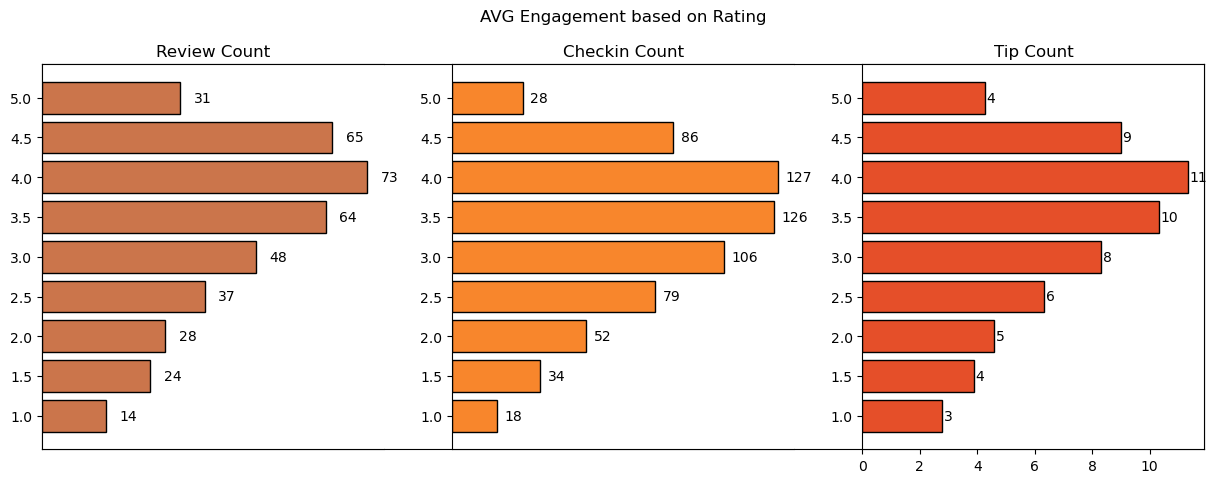

In [19]:
plt.figure(figsize=(15,5))
plt.title('AVG Engagement based on Rating\n\n')
plt.yticks([])
plt.xticks([])

plt.subplot(1,3,1)
plt.title('Review Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_review_count'], edgecolor = 'k', color = '#CB754B')
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_review_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')

plt.xticks([])
plt.subplot(1,3,2)
plt.title('Checkin Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_checkin_count'], edgecolor = 'k', color = '#F8862C')
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_checkin_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')

plt.xticks([])
plt.subplot(1,3,3)
plt.title('Tip Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_tip_count'], edgecolor = 'k',color='#E54F29')
for i, value in enumerate(review_count_df['avg_tip_count']):
    plt.text(value+0.05, i, str(round(value)), color='black', va='center')

plt.show()

In [32]:
# 4 rating is threshold level

# Is there a correlation between the number of reviews, tips, and check-ins for a business?
engagement_df = pd.read_sql_query(f"""SELECT 
b.business_id,
SUM(b.review_count) AS review_count,
AVG(b.stars) AS avg_rating,
SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
SUM(tip.tip_count) as tip_count
FROM
business b
LEFT JOIN
checkin cc ON b.business_id = cc.business_id
LEFT JOIN
(select business_id, count(business_id) as tip_count from tip GROUP BY business_id ORDER BY tip_count) as tip on b.business_id = tip.business_id
WHERE b.business_id IN {tuple(business_id['business_id'])}
GROUP BY
b.business_id
""", conn).dropna() # to remove null val where tip is 0

In [21]:
engagement_df[['review_count','checkin_count','tip_count']].corr()

,review_count,checkin_count,tip_count
review_count,1.000000,0.626837,0.766273
checkin_count,0.626837,1.000000,0.772061
tip_count,0.766273,0.772061,1.000000


In [22]:
#0.62 is corr coeff, >0.5 is +ve corr

<Axes: >

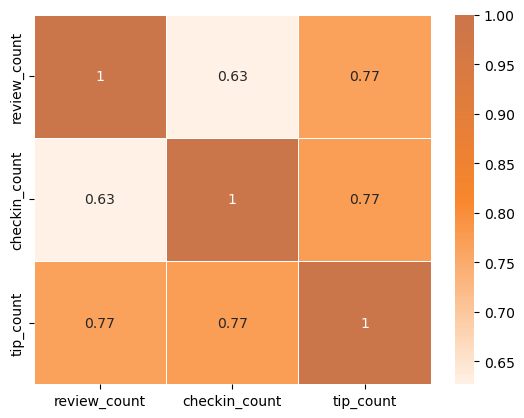

In [23]:
#heatmap

# Define the color gradient
colors = ['#FFF1E5', '#F8862C', '#CB754B']
custom_cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Create heatmap
sns.heatmap(
    engagement_df[['review_count', 'checkin_count', 'tip_count']].corr(),
    cmap=custom_cmap,
    annot=True,
    linewidths=0.5,
    linecolor='white'
)



In [33]:
# Is there a difference in the user engagement (reviews, tips, and check-ins) between high-rated and low-rated businesses?
# >3.5 = high else low
engagement_df = pd.read_sql_query(f"""SELECT
b.business_id,
SUM(b.review_count) AS review_count,
AVG(b.stars) AS avg_rating,
SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
SUM(tip.tip_count) as tip_count,
(CASE WHEN b.stars >= 3.5 Then 'High-Rated' Else 'Low-Rated' END) as category
FROM
business b
LEFT JOIN
checkin cc ON b.business_id = cc.business_id
LEFT JOIN
(select business_id, count(business_id) as tip_count from tip GROUP BY business_id ORDER BY tip_count) as tip on b.business_id = tip.business_id
WHERE b.business_id IN {tuple(business_id['business_id'])}
GROUP BY
b.business_id
""", conn).dropna()

In [25]:
engagement_df.groupby("category")[['review_count','tip_count','checkin_count']].mean()

,review_count,tip_count,checkin_count
category,,,
High-Rated,72.319991,10.166411,122.106865
Low-Rated,42.132915,6.543136,88.905759


In [26]:
# function to calculate the success score based on the avg rating and total review count
def calculate_success_metric(df):
    success_score = []
    for index, row in df.iterrows():
        score = row['avg_rating'] * np.log(row['review_count'] + 1)
        success_score.append(score)
    return success_score

In [27]:
# How do the success metrics (review_count or avg_rating) of restaurants vary across different states and cities?
# in which top 10 city/state, rest success is high
city_df = pd.read_sql_query(f"""select city, state, latitude, longitude, AVG(stars) as avg_rating, SUM(review_count) as review_count,
count(*) as restaurant_count
from business
WHERE business_id IN {tuple(business_id['business_id'])}
group by state, city
order by review_count desc
limit 10 """,conn)

city_df['success_score']=calculate_success_metric(city_df)

In [28]:
city_df

,city,state,latitude,longitude,avg_rating,review_count,restaurant_count,success_score
0,Philadelphia,PA,39.955505,-75.155564,3.532011,175470,2999,42.649838
1,Tampa,FL,27.890814,-82.502346,3.571179,104368,1714,41.267425
2,Indianapolis,IN,39.637133,-86.127217,3.412111,92639,1701,39.022521
3,Tucson,AZ,32.338572,-111.010760,3.385512,91562,1415,38.678743
4,Nashville,TN,36.208102,-86.768170,3.493590,87070,1404,39.737764
5,New Orleans,LA,29.963974,-90.042604,3.692878,69233,1011,41.158043
6,Saint Louis,MO,38.583223,-90.407187,3.412963,51482,810,37.027259
7,Reno,NV,39.476518,-119.784037,3.478705,48340,587,37.521438
8,Edmonton,AB,53.436403,-113.604288,3.509379,45916,1546,37.671748
9,Boise,ID,43.611192,-116.206275,3.558140,36087,559,37.338105


In [29]:
#review-count may be more, but rating maybe less


In [30]:
# Create a base map
m = folium.Map(location=[city_df['latitude'].mean(), city_df['longitude'].mean()], zoom_start=4)

# Define a color scale
color_scale = folium.LinearColormap(colors=['green', 'yellow', '#E54F29'],
                                    vmin=city_df['success_score'].min(),
                                    vmax=city_df['success_score'].max())

# Add markers to the map
for index, row in city_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_scale(row['success_score']),
        fill=True,
        fill_color=color_scale(row['success_score']),
        fill_opacity=0.7,
        popup=f"Success Score: {row['success_score']}"
    ).add_to(m)

# Add color scale to the map
m.add_child(color_scale)

In [47]:
# Are there any patterns in user engagement over time for successful businesses compared to less successful ones?
# Are there any seasonal trends in the user engagement for restaurants?

high_rated_engagement = pd.read_sql_query(f"""
SELECT review.month_year, review.review_count, tip.tip_count FROM
(SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) AS review_count
FROM review
WHERE business_id IN {tuple(business_id['business_id'])} and stars >= 3.5
GROUP BY month_year
ORDER BY month_year) as review
JOIN
(SELECT AVG(b.stars), strftime('%m-%Y', tip.date) AS month_year, COUNT(*) AS tip_count
FROM tip
JOIN business as b
on tip.business_id = b.business_id
WHERE tip.business_id IN {tuple(business_id['business_id'])} and b.stars >= 3.5
GROUP BY month_year
ORDER BY month_year) as tip

on review.month_year = tip.month_year
;""",conn)

low_rated_engagement = pd.read_sql_query(f"""
SELECT review.month_year, review.review_count, tip.tip_count FROM
(SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) AS review_count
FROM review
WHERE business_id IN {tuple(business_id['business_id'])} and stars < 3.5
GROUP BY month_year
ORDER BY month_year) as review
JOIN
(SELECT AVG(b.stars), strftime('%m-%Y', tip.date) AS month_year, COUNT(*) AS tip_count
FROM tip
JOIN business as b
on tip.business_id = b.business_id
WHERE tip.business_id IN {tuple(business_id['business_id'])} and b.stars < 3.5
GROUP BY month_year
ORDER BY month_year) as tip

on review.month_year = tip.month_year
;""",conn)


In [48]:
high_rated_engagement

,month_year,review_count,tip_count
0,01-2010,43,79
1,01-2011,45,621
2,01-2012,57,1321
3,01-2013,93,1230
4,01-2014,93,1356
...,...,...,...
107,12-2013,91,1278
108,12-2014,121,1065
109,12-2015,187,1457
110,12-2016,160,1539


In [49]:
low_rated_engagement

,month_year,review_count,tip_count
0,01-2010,18,25
1,01-2011,27,297
2,01-2012,27,538
3,01-2013,44,548
4,01-2014,78,607
...,...,...,...
105,12-2013,70,552
106,12-2014,87,446
107,12-2015,87,496
108,12-2016,89,478


In [50]:
#On the basis of month and yaer, for every month whats the avg rating of whole business
time_rating = pd.read_sql_query(f"""SELECT strftime('%m-%Y', date) AS month_year, AVG(stars) as avg_rating
FROM review
WHERE business_id IN {tuple(business_id['business_id'])}
GROUP BY month_year
ORDER BY month_year
;""", conn)

In [51]:
time_rating

,month_year,avg_rating
0,01-2006,4.333333
1,01-2007,3.500000
2,01-2008,3.200000
3,01-2009,3.500000
4,01-2010,3.819672
...,...,...
139,12-2013,3.391304
140,12-2014,3.447115
141,12-2015,3.638686
142,12-2016,3.642570


In [58]:
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace = True)
time_rating = time_rating[time_rating['month_year'] > pd.to_datetime('2017-01-01')]

high_rated_engagement['month_year'] = pd.to_datetime(high_rated_engagement['month_year'])
high_rated_engagement.sort_values('month_year', inplace = True)
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year'] > pd.to_datetime('2017-01-01')]

low_rated_engagement['month_year'] = pd.to_datetime(low_rated_engagement['month_year'])
low_rated_engagement.sort_values('month_year', inplace = True)
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year'] > pd.to_datetime('2017-01-01')]


In [69]:
high_rated_engagement['avg_rating'] = time_rating['avg_rating'].values

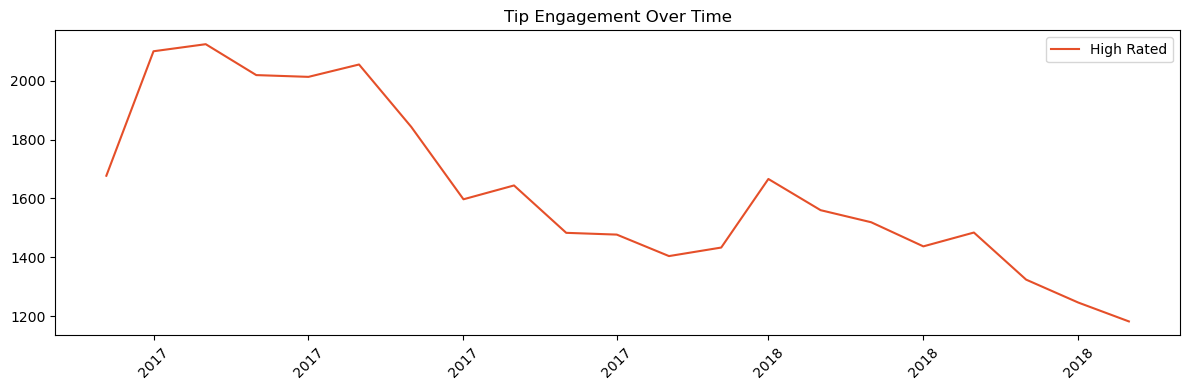

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Sample test with one plot — apply same to others later
plt.figure(figsize=(12, 4))
ax = plt.gca()

# Plot high-rated tips only for simplicity
ax.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label='High Rated', color='#E54F29')

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # Label only year

# Rotate x-tick labels
plt.xticks(rotation=45)

plt.title('Tip Engagement Over Time')
plt.legend()
plt.tight_layout()
plt.show()


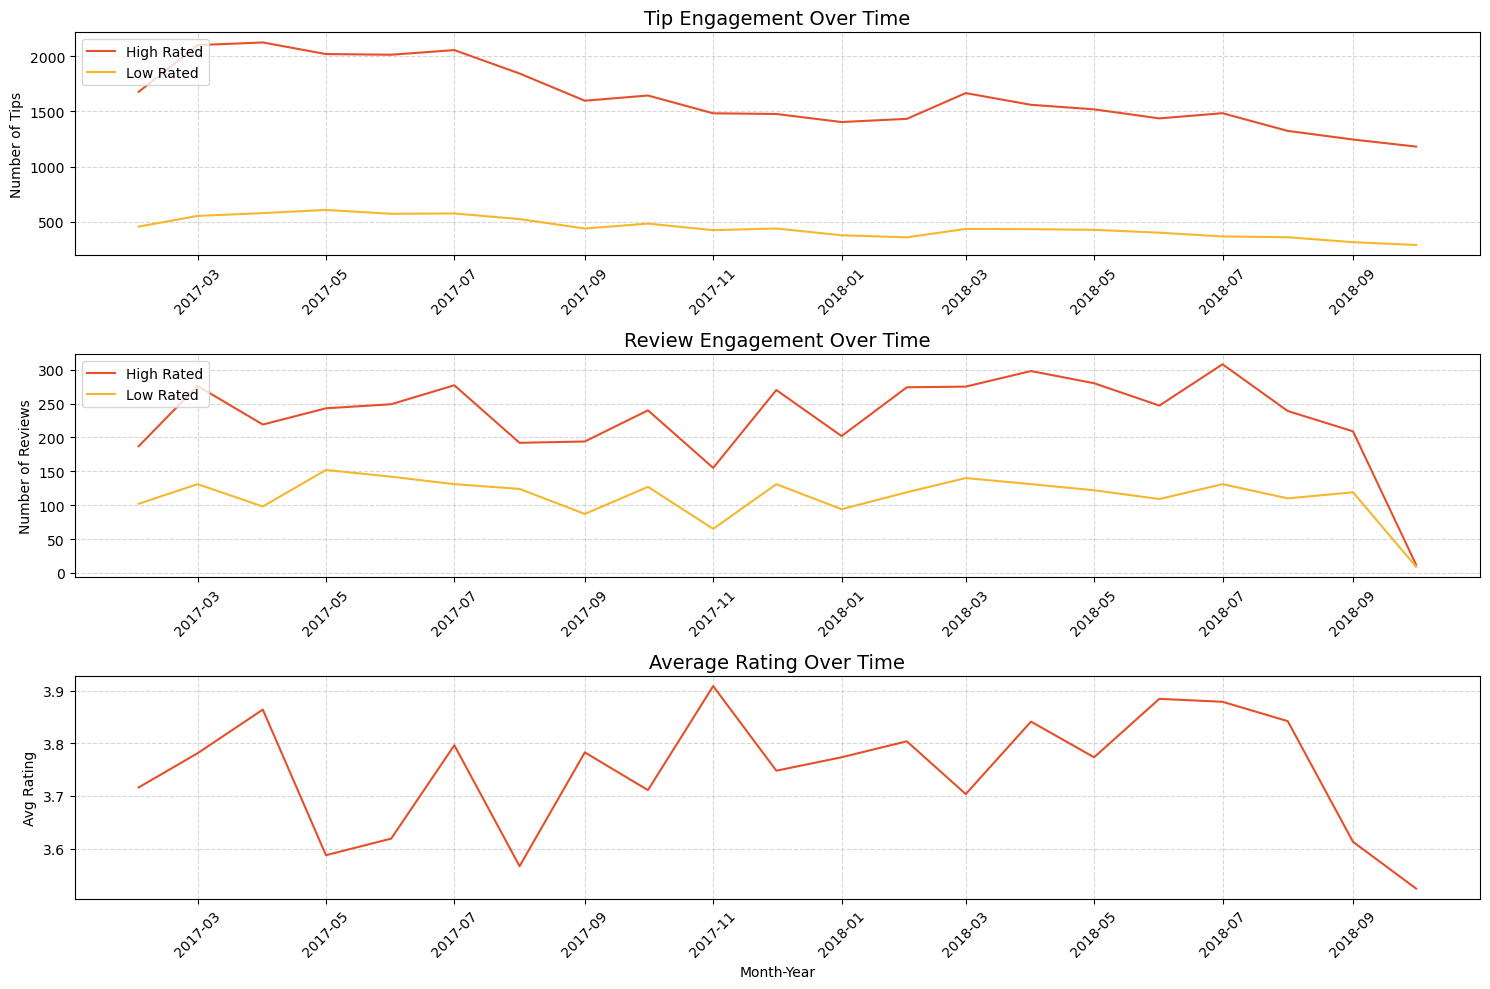

In [73]:
plt.figure(figsize=(15, 10))

# Plot 1: Tip Engagement
plt.subplot(3, 1, 1)
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['tip_count'], label='Low Rated', color='#F8B62C')
plt.title('Tip Engagement Over Time', fontsize=14)
plt.ylabel('Number of Tips')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Plot 2: Review Engagement
plt.subplot(3, 1, 2)
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['review_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['review_count'], label='Low Rated', color='#F8B62C')
plt.title('Review Engagement Over Time', fontsize=14)
plt.ylabel('Number of Reviews')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Plot 3: Average Rating
plt.subplot(3, 1, 3)
plt.plot(time_rating['month_year'], time_rating['avg_rating'], color='#E54F29')
plt.title('Average Rating Over Time', fontsize=14)
plt.ylabel('Avg Rating')
plt.xlabel('Month-Year')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [74]:
tip_high_rated = high_rated_engagement[['month_year', 'tip_count']].set_index('month_year')
review_high_rated = high_rated_engagement[['month_year', 'review_count']].set_index('month_year')
rating_df = time_rating[['month_year', 'avg_rating']].set_index('month_year')

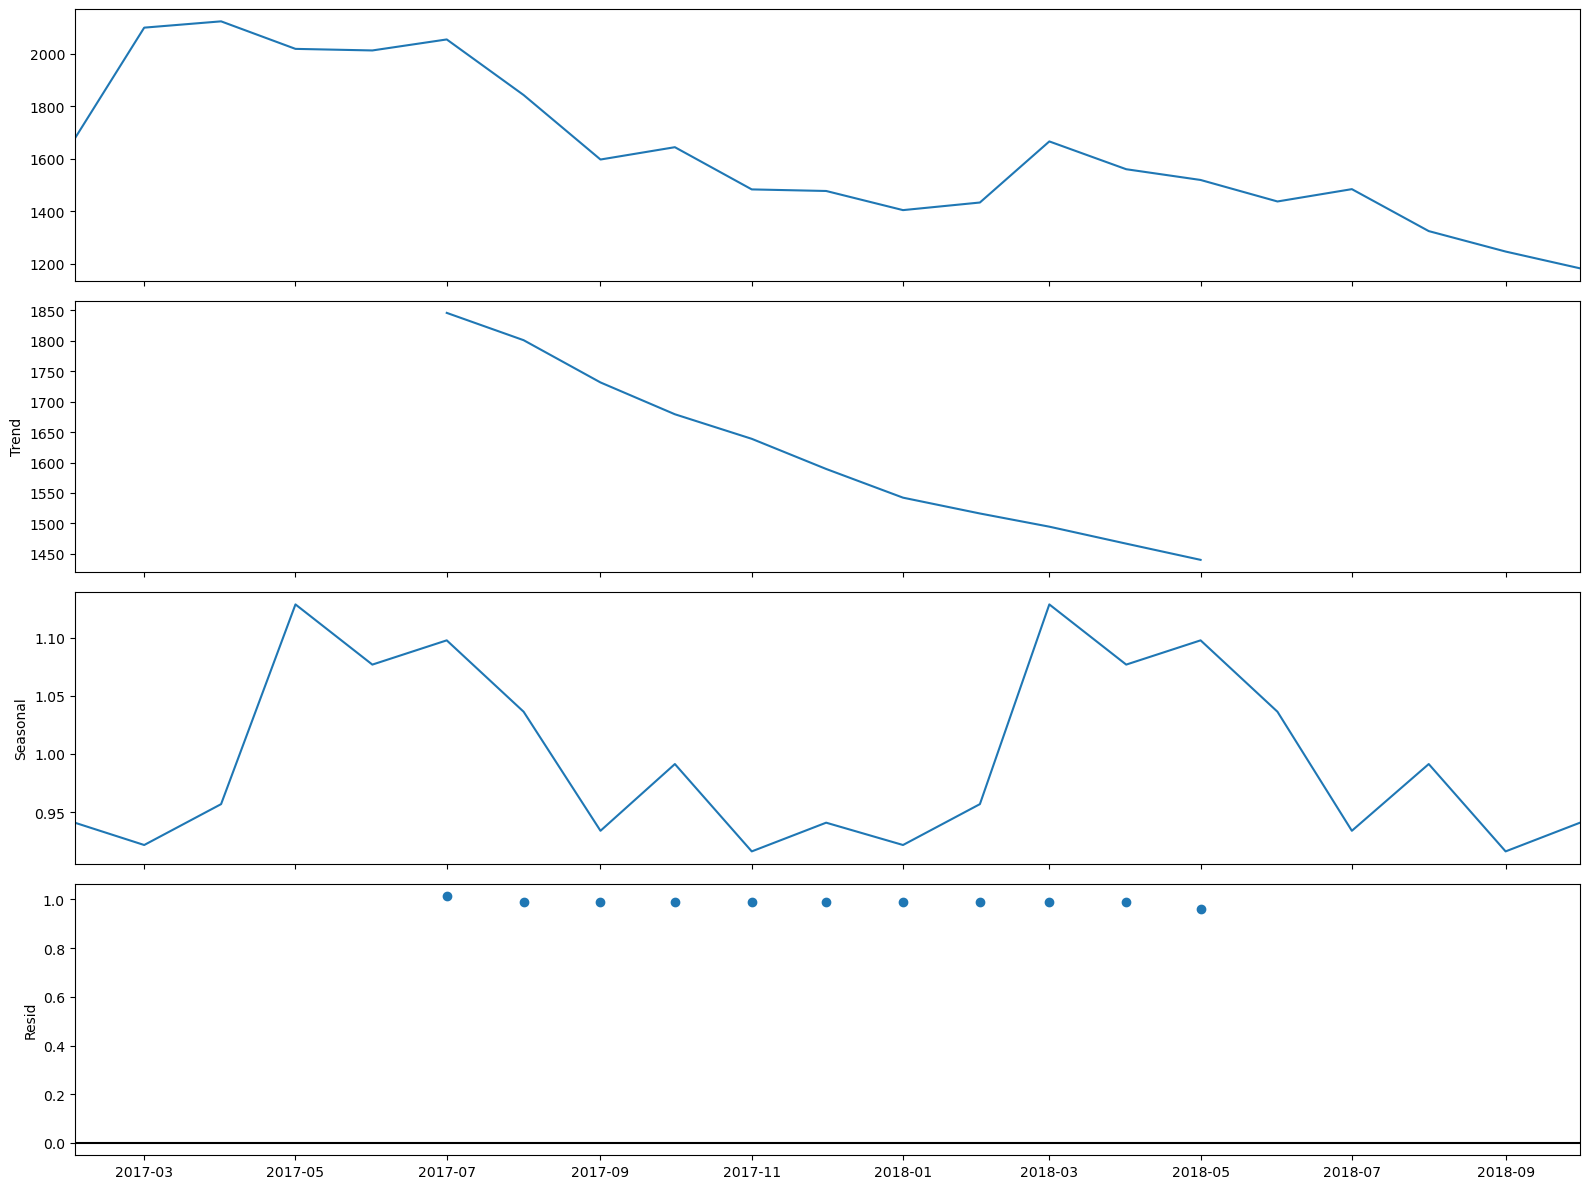

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(tip_high_rated,
                                                    model='multiplicative', period = 10)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot()
plt.show()

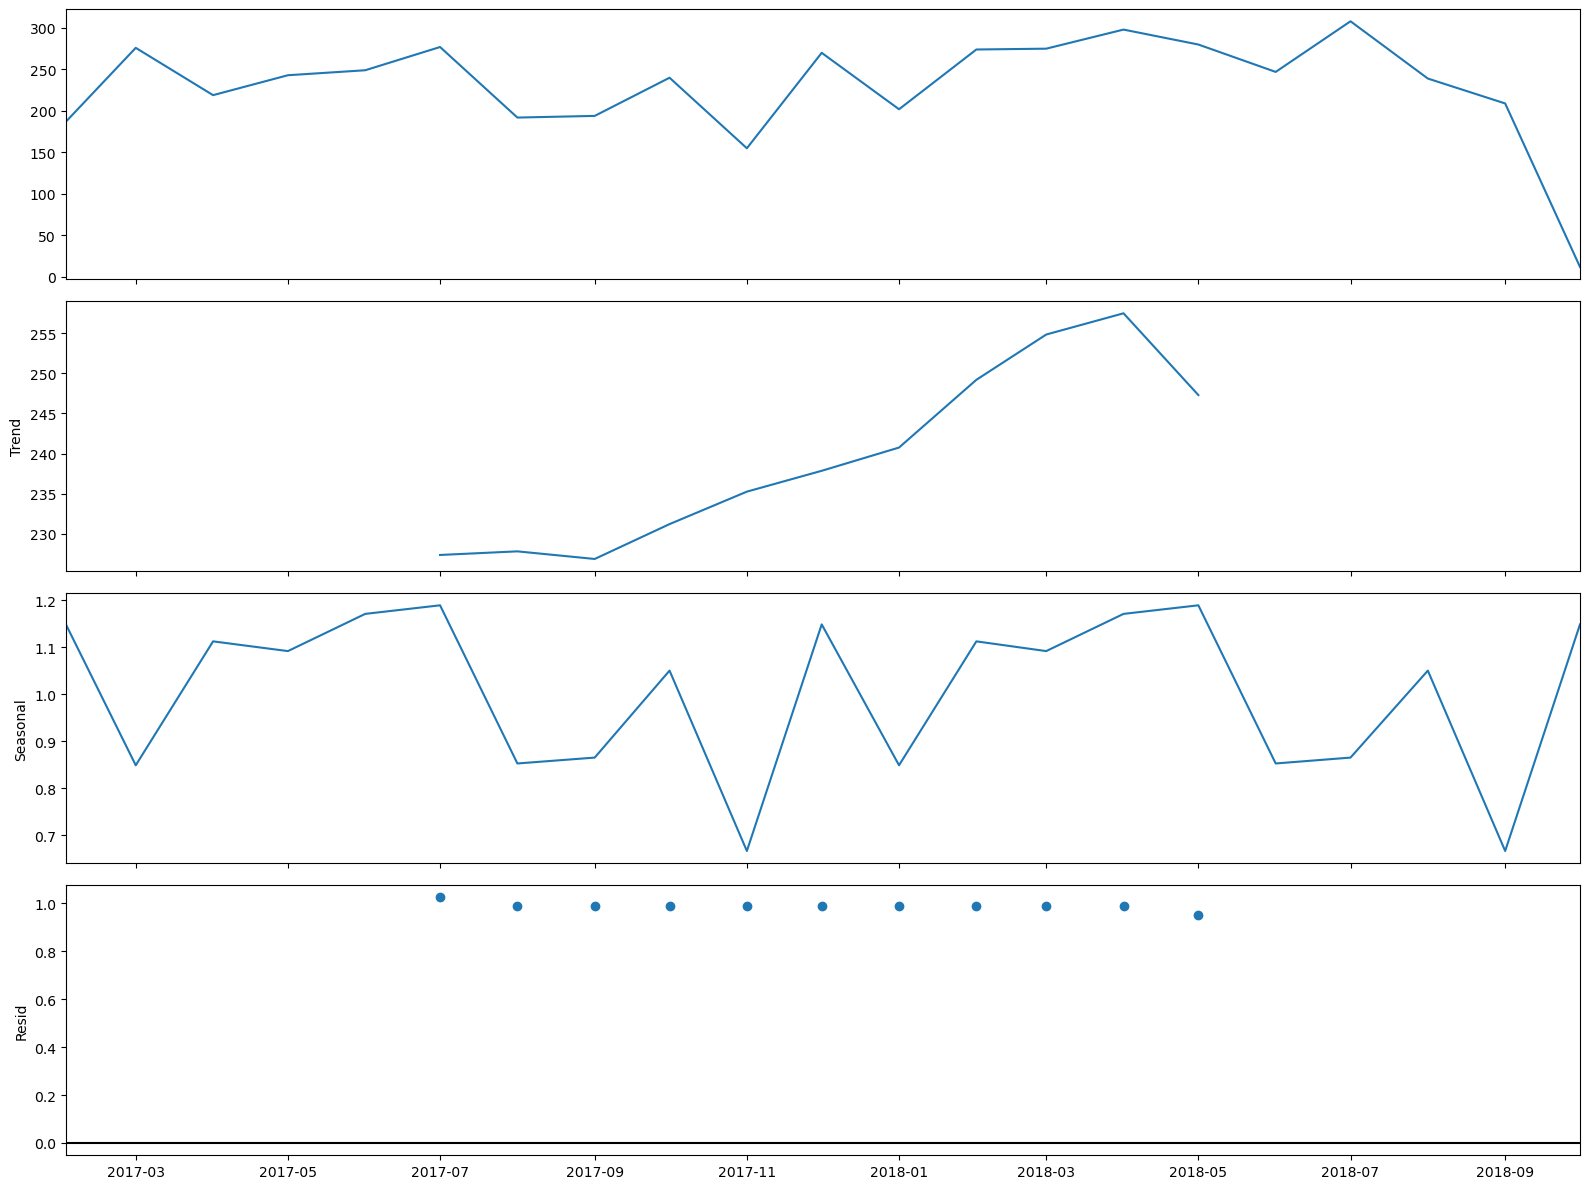

In [77]:
multiplicative_decomposition = seasonal_decompose(review_high_rated,
                                                    model='multiplicative', period = 10)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot()
plt.show()

In [82]:
# How does the sentiment of reviews and tips (useful, funny, cool) correlate with the success metrics of restaurants?
sentiment_df = pd.read_sql_query(f"""SELECT b.business_id, AVG(b.stars) as avg_rating, SUM(b.review_count) as review_count,
SUM(s.useful_count) as useful_count,
SUM(s.funny_count) as funny_count,
SUM(s.cool_count) as cool_count
FROM
(SELECT business_id,
SUM(useful) as useful_count,
SUM(funny) as funny_count,
SUM(cool) as cool_count
FROM
review
GROUP BY business_id) as s
JOIN business as b on b.business_id = s.business_id

WHERE b.business_id IN {tuple(business_id['business_id'])}
GROUP BY b.business_id
ORDER BY review_count""",conn)

#remove outliers
sentiment_df = remove_outliers(sentiment_df, 'review_count')
sentiment_df = remove_outliers(sentiment_df, 'useful_count')
sentiment_df = remove_outliers(sentiment_df, 'funny_count')
sentiment_df = remove_outliers(sentiment_df, 'cool_count')

In [83]:
sentiment_df['success_score'] = calculate_success_metric(sentiment_df)


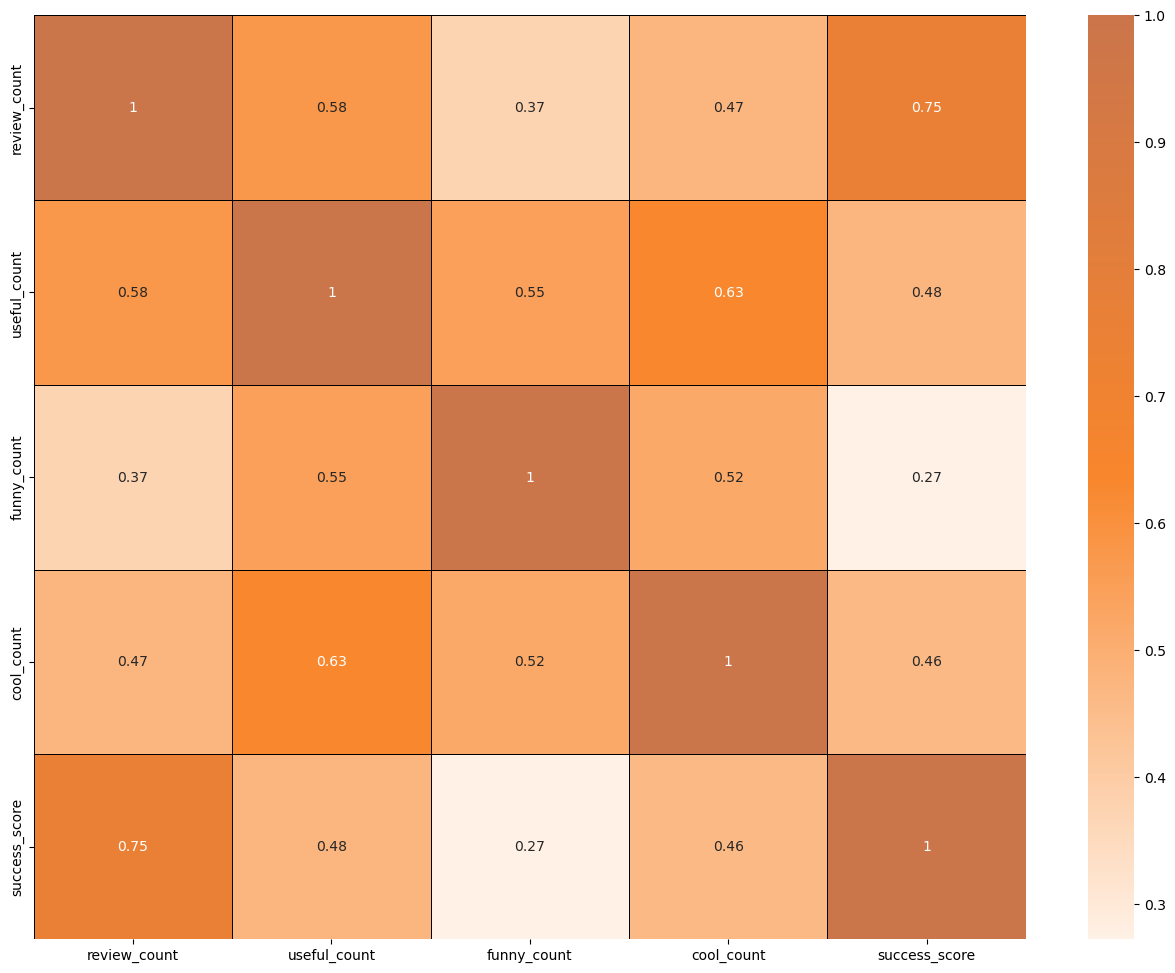

In [84]:

sns.heatmap(sentiment_df.iloc[:,2:].corr(), cmap = custom_cmap, annot = True, linewidths=0.5, linecolor = 'black')
plt.show()

In [87]:
# Is there any difference in engagement of elite users and non elite users?
elite_df = pd.read_sql_query("""SELECT
elite,
COUNT(*) AS num_users,
SUM(review_count) AS total_review_count
FROM
(SELECT
CASE
WHEN elite = '' THEN 'Not Elite'
ELSE 'Elite'
END AS elite,
u.review_count
FROM
user u) AS user_elite
GROUP BY
elite;
""",conn)

In [88]:
elite_df

,elite,num_users,total_review_count
0,Elite,13047,4816789
1,Not Elite,36953,1856117


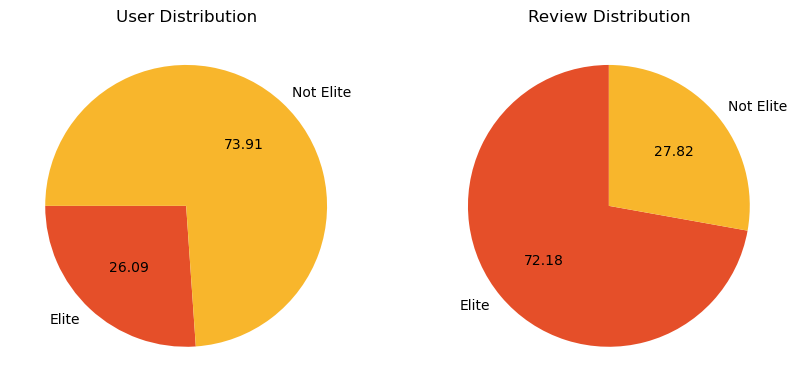

In [89]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('User Distribution')
plt.pie(elite_df['num_users'], labels = elite_df['elite'], autopct='%.2f', startangle = 180, colors = ['#E54F29', '#F8B62C'])

plt.subplot(1,2,2)
plt.title('Review Distribution')
plt.pie(elite_df['total_review_count'], labels = elite_df['elite'], autopct='%.2f', startangle = 90, colors = ['#E54F29', '#F8B62C'])
plt.show()

In [90]:
# so elite user are giving nice reviews and r active


In [94]:
# What are the busiest hours for restaurants?
review_engagement = pd.read_sql_query("""SELECT
cast (strftime('%H',date) as integer)
as hour,
COUNT(*) AS review_count
FROM
review
GROUP BY
hour;
""", conn)

tip_engagement = pd.read_sql_query("""SELECT
cast (strftime('%H',date) as integer)
as hour,
COUNT(*) AS tip_count
FROM
tip
GROUP BY
hour;
""", conn)


checkin = pd.read_sql_query("""SELECT date FROM checkin""",conn)
checkin_engagement = []
for i in checkin['date']:
    checkin_engagement.extend([datetime.strptime(j.strip(),"%Y-%m-%d %H:%M:%S").strftime("%H") for j in i.split(',')])

checkin_engagement = pd.DataFrame(checkin_engagement).astype('int').groupby(0)[0].count()

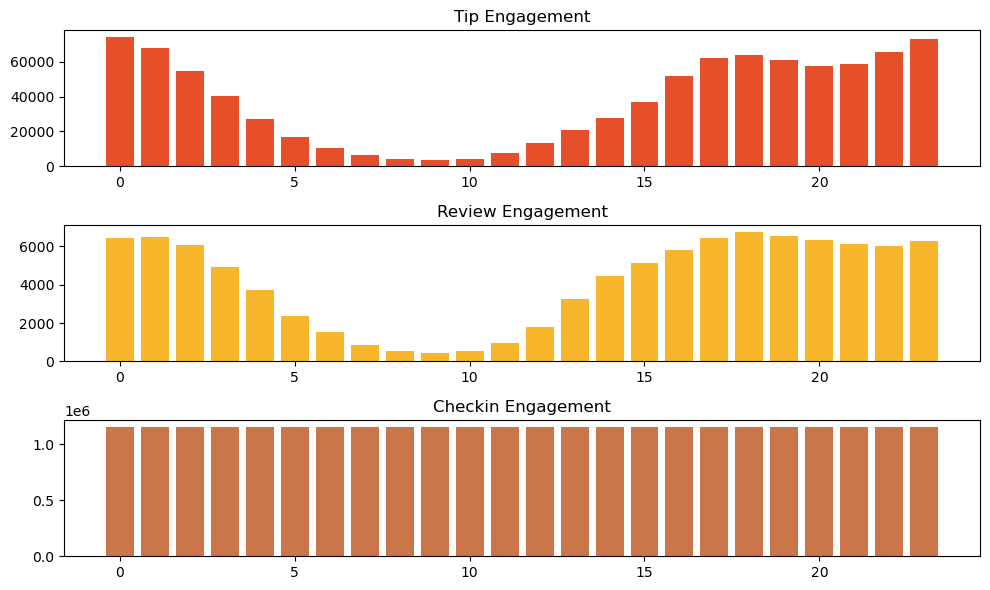

In [95]:
plt.figure(figsize = (10,6))
plt.subplot(3,1,1)
plt.title('Tip Engagement')
plt.bar(tip_engagement['hour'], tip_engagement['tip_count'], color = '#E54F29')
plt.subplot(3,1,2)
plt.title('Review Engagement')
plt.bar(review_engagement['hour'], review_engagement['review_count'], color = '#F8B62C')
plt.subplot(3,1,3)
plt.title('Checkin Engagement')
plt.bar(checkin_engagement.index, checkin_engagement[0], color = '#CB754B')
plt.tight_layout()
plt.show()

<b>Data Overview<b>

This dataset is a subset of Yelp and has information about businesses across 8 metropolitan areas in the USA and Canada.

The original data is shared by Yelp as JSON files.

The five JSON files are business, review, user, tip and checkin.

The JSON files are stored in the database for easy retrieval of data.


<b>Analysis and Findings<b>

Out of 150k businesses, 35k are restaurants business and are open.

Table showing distribution of business success metrics (review count and average rating):



Higher ratings do not guarantee a higher review count, or vice versa.

Success of Restaurants is not solely determined by ratings or review counts.

Review count reflects user engagement but not necessarily overall customer satisfaction or business performance.




<b>Do restaurants with higher engagement tend to have higher ratings?<b>

Data shows a general increase in average review, check-in, and tip counts as ratings improve from 1 to 4 stars.

Restaurants rated 4 stars exhibit the highest engagement and shows a downward trend for rating above 4.

The drop in engagement at 5.0 stars might suggest either a saturation point where fewer customers feel compelled to add their reviews, or a selectivity where only a small, satisfied audience frequents these establishments.



<h3><b>Is there a correlation between the number of reviews, tips, and check-ins for a business?<b></b></h3>

These correlations suggest that user engagement across different platforms (reviews, tips, and check-ins) is interlinked; higher activity in one area tends to be associated with higher activity in others.

Businesses should focus on strategies that boost all types of user engagement, as increases in one type of engagement are likely to drive increases in others, enhancing overall visibility and interaction with customers.



<b>Is there a difference in the user engagement between high-rated and low-rated businesses?<b>

Data indicates a clear correlation between higher ratings and increased user engagement across reviews, tips, and check-ins.

This pattern underscores the importance of maintaining high service and quality standards, as these appear to drive more reviews, check-ins, and tips, which are critical metrics of customer engagement and satisfaction.



<b>How do the success metrics of restaurants vary across different states and cities?<b>

Philadelphia emerges as the top city with the highest success score, indicating a combination of high ratings and active user engagement.

Following Philadelphia, Tampa, Indianapolis, and Tucson rank among the top cities with significant success scores, suggesting thriving restaurant scenes in these areas.



<b>Are there any patterns in user engagement over time for successful businesses compared to less successful ones?<b>

Successful businesses, particularly those with higher ratings (above 3.5), exhibit consistent and possibly increasing user engagement over time.

High rated restaurants maintain a steady or growing level of user engagement over time, reflecting ongoing customer interest and satisfaction.




<b>How does the sentiment of reviews and tips (useful, funny, cool) correlate with the success metrics of restaurants?<b>

"useful," "funny," and "cool" are attributes associated with user reviews. They represent the feedback provided by users about the usefulness, humor, or coolness of a particular review.

Higher counts of useful, funny, and cool reviews suggest greater user engagement and satisfaction, which are key factors contributing to a restaurant's success.



<b>Is there any difference in engagement of elite users and non elite users?<b>

Elite users are individuals who have been recognized and awarded the "Elite" status by Yelp for their active and high-quality contributions.

Elite users, despite being significantly fewer in number, contribute a substantial proportion of the total review count compared to non-elite users.

Establishing a positive relationship with elite users can lead to repeat visits and loyalty, as they are more likely to continue supporting businesses they have had good experiences with.



<b>Busiest Hours<b>

The busiest hours for restaurants, based on user engagement, span from 4 pm to 1 am.

Knowing the peak hours allows businesses to optimize their staffing levels and resource allocation during these times to ensure efficient operations and quality service delivery.


The concentration of user engagement during the evening and night hours suggests a higher demand for dining out during these times, potentially driven by factors such as work schedules, social gatherings, and leisure activities.



<b>Recommendations<b>

Utilizing insights from the analysis of various metrics such as user engagement, sentiment of reviews, peak hours, and the impact of elite users, businesses can make informed decisions to drive success.

Collaborating with elite users and leveraging their influence can amplify promotional efforts, increase brand awareness, and drive customer acquisition.

Businesses can adjust their operating hours or introduce special promotions to capitalize on the increased demand during peak hours.

Less successful businesses may need to focus on strategies to enhance user engagement over time, such as improving service quality, responding to customer feedback.

Cities with high success scores presents opportunities for restaurant chains to expand or invest further